Solving 2x2 puzzle using MST Assembly...
Assembled 4/4 pieces.


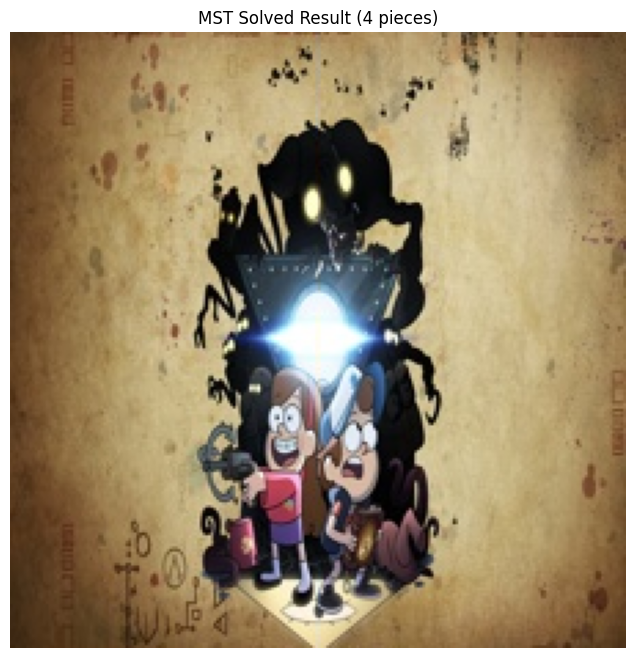

In [52]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Paths
json_path = r"Tests/test_001/extractor_runs/20251213_033802/descriptors.json"
image_dir = r"Tests/test_001/images"
target_image_name = "2x2_47.jpg" 

# 2. Load Data
with open(json_path, 'r') as f:
    descriptors = json.load(f)

samples = [d for d in descriptors if d['source_image'] == target_image_name]
samples.sort(key=lambda x: x['id']) 

if not samples:
    print(f"No descriptors found for {target_image_name}.")
else:
    # 3. Load Source Image & Extract Pieces
    img_path = os.path.join(image_dir, target_image_name)
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found at {img_path}")

    full_image = cv2.imread(img_path)
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)

    pieces = []
    for sample in samples:
        bbox = sample['bbox']
        x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
        crop = full_image[y:y+h, x:x+w]
        pieces.append(crop)

    # 4. Solver: MST-based Assembly (Kruskal's Algorithm)
    # This is much more robust than greedy filling. It builds "strong" connections first.
    
    pieces_lab = [cv2.cvtColor(p, cv2.COLOR_RGB2LAB).astype(np.float32) for p in pieces]
    n_pieces = len(pieces)
    grid_size = int(np.sqrt(n_pieces))
    print(f"Solving {grid_size}x{grid_size} puzzle using MST Assembly...")

    # 4a. Compute all pairwise edge costs
    edges = []
    for i in range(n_pieces):
        for j in range(n_pieces):
            if i == j: continue
            
            # Horizontal: i | j (Right of i vs Left of j)
            diff_h = pieces_lab[i][:, -1, :] - pieces_lab[j][:, 0, :]
            cost_h = np.mean(diff_h ** 2)
            edges.append((cost_h, i, j, 'h'))
            
            # Vertical: i / j (Bottom of i vs Top of j)
            diff_v = pieces_lab[i][-1, :, :] - pieces_lab[j][0, :, :]
            cost_v = np.mean(diff_v ** 2)
            edges.append((cost_v, i, j, 'v'))

    # Sort edges by cost (lowest cost = best match first)
    edges.sort(key=lambda x: x[0])

    # 4b. Initialize Clusters
    # Each cluster is a dict: {piece_id: (relative_row, relative_col)}
    clusters = [{i: (0, 0)} for i in range(n_pieces)]
    piece_to_cluster = list(range(n_pieces)) # Lookup table

    def get_cluster_bounds(cluster_dict):
        rs = [p[0] for p in cluster_dict.values()]
        cs = [p[1] for p in cluster_dict.values()]
        return min(rs), max(rs), min(cs), max(cs)

    def merge_clusters(cid1, cid2, shift_r, shift_c):
        c1 = clusters[cid1]
        c2 = clusters[cid2]
        
        # Check 1: Overlap
        new_positions = {}
        for pid, (r, c) in c2.items():
            nr, nc = r + shift_r, c + shift_c
            # Check if this position is already occupied in c1 (by a different piece)
            # Note: We need to check values() of c1. 
            # Since (nr, nc) is a tuple, we can check existence.
            if (nr, nc) in c1.values():
                return False
            new_positions[pid] = (nr, nc)
            
        # Check 2: Grid Dimensions
        # Combine positions temporarily to check bounds
        all_pos = list(c1.values()) + list(new_positions.values())
        rs = [p[0] for p in all_pos]
        cs = [p[1] for p in all_pos]
        h_span = max(rs) - min(rs) + 1
        w_span = max(cs) - min(cs) + 1
        
        if h_span > grid_size or w_span > grid_size:
            return False
            
        # Execute Merge
        c1.update(new_positions)
        for pid in c2:
            piece_to_cluster[pid] = cid1
        clusters[cid2] = {} # Clear old cluster
        return True

    # 4c. Build the Puzzle
    for cost, p1, p2, relation in edges:
        cid1 = piece_to_cluster[p1]
        cid2 = piece_to_cluster[p2]
        
        if cid1 == cid2:
            continue # Already in same cluster
            
        # Calculate required shift
        # We want p2 to be at a specific position relative to p1
        r1, c1 = clusters[cid1][p1]
        r2, c2 = clusters[cid2][p2]
        
        if relation == 'h': # p1 | p2 -> p2 is at (r1, c1+1)
            target_r, target_c = r1, c1 + 1
        else: # p1 / p2 -> p2 is at (r1+1, c1)
            target_r, target_c = r1 + 1, c1
            
        shift_r = target_r - r2
        shift_c = target_c - c2
        
        merge_clusters(cid1, cid2, shift_r, shift_c)

    # 5. Reconstruct Result
    final_cluster = max(clusters, key=len)
    min_r, max_r, min_c, max_c = get_cluster_bounds(final_cluster)
    
    # Create canvas
    h, w, _ = pieces[0].shape
    canvas_h = (max_r - min_r + 1) * h
    canvas_w = (max_c - min_c + 1) * w
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
    
    print(f"Assembled {len(final_cluster)}/{n_pieces} pieces.")
    
    for pid, (r, c) in final_cluster.items():
        # Normalize coordinates to 0-based for canvas
        norm_r = r - min_r
        norm_c = c - min_c
        canvas[norm_r*h:(norm_r+1)*h, norm_c*w:(norm_c+1)*w] = pieces[pid]

    plt.figure(figsize=(8, 8))
    plt.imshow(canvas)
    plt.title(f"MST Solved Result ({len(final_cluster)} pieces)")
    plt.axis('off')
    plt.show()

In [33]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_boundary_features(img_lab, side):
    """
    Returns the boundary pixels and the 'inner' pixels for gradient prediction.
    side: 'top', 'bottom', 'left', 'right'
    """
    if side == 'right':
        boundary = img_lab[:, -1, :]
        inner = img_lab[:, -2, :]
    elif side == 'left':
        boundary = img_lab[:, 0, :]
        inner = img_lab[:, 1, :]
    elif side == 'bottom':
        boundary = img_lab[-1, :, :]
        inner = img_lab[-2, :, :]
    elif side == 'top':
        boundary = img_lab[0, :, :]
        inner = img_lab[1, :, :]
    return boundary, inner

def calculate_dissimilarity(p1_lab, p2_lab, relation):
    """
    Computes dissimilarity between p1 and p2 given the relation (p1 is 'relation' of p2).
    relation: 'h' (p1 is left of p2), 'v' (p1 is top of p2)
    Uses linear prediction: Pred = 2*Boundary - Inner
    """
    if relation == 'h':
        # p1 right vs p2 left
        b1, i1 = get_boundary_features(p1_lab, 'right')
        b2, i2 = get_boundary_features(p2_lab, 'left')
    else:
        # p1 bottom vs p2 top
        b1, i1 = get_boundary_features(p1_lab, 'bottom')
        b2, i2 = get_boundary_features(p2_lab, 'top')
        
    # Linear Prediction: Expect the gradient to continue
    pred1 = 2.0 * b1 - i1
    pred2 = 2.0 * b2 - i2
    
    # Error: (Pred1 - B2) + (Pred2 - B1)
    # This is symmetric and handles gradients better than raw SSD
    diff1 = np.mean(np.sum((pred1 - b2)**2, axis=1))
    diff2 = np.mean(np.sum((pred2 - b1)**2, axis=1))
    
    return diff1 + diff2

def solve_puzzle_robust(pieces):
    n = len(pieces)
    if n == 0: return {}
    grid_size = int(np.sqrt(n))
    
    # Convert to LAB
    pieces_lab = [cv2.cvtColor(p, cv2.COLOR_RGB2LAB).astype(np.float32) for p in pieces]
    
    # 1. Compute Raw Costs Matrix
    # costs[i][j][0] = cost(i left of j)
    # costs[i][j][1] = cost(i top of j)
    raw_costs = np.full((n, n, 2), np.inf)
    
    for i in range(n):
        for j in range(n):
            if i == j: continue
            raw_costs[i, j, 0] = calculate_dissimilarity(pieces_lab[i], pieces_lab[j], 'h')
            raw_costs[i, j, 1] = calculate_dissimilarity(pieces_lab[i], pieces_lab[j], 'v')
            
    # 2. Compute Ratio Scores (Lowe's Ratio Test)
    # We want to prioritize matches that are uniquely good.
    edges = []
    
    # For each piece's Right side, find best Left match
    for i in range(n):
        # Horizontal candidates for i's right neighbor
        candidates_h = [(raw_costs[i, j, 0], j) for j in range(n) if i != j]
        candidates_h.sort() # Sort by cost
        
        best_cost, best_j = candidates_h[0]
        second_cost, _ = candidates_h[1] if len(candidates_h) > 1 else (best_cost * 2 + 1e-6, -1)
        
        # Ratio: How much better is the best match compared to the second best?
        # Lower is better (more distinct).
        ratio = best_cost / (second_cost + 1e-6)
        edges.append({'ratio': ratio, 'p1': i, 'p2': best_j, 'rel': 'h', 'raw': best_cost})

    # For each piece's Bottom side, find best Top match
    for i in range(n):
        candidates_v = [(raw_costs[i, j, 1], j) for j in range(n) if i != j]
        candidates_v.sort()
        
        best_cost, best_j = candidates_v[0]
        second_cost, _ = candidates_v[1] if len(candidates_v) > 1 else (best_cost * 2 + 1e-6, -1)
        
        ratio = best_cost / (second_cost + 1e-6)
        edges.append({'ratio': ratio, 'p1': i, 'p2': best_j, 'rel': 'v', 'raw': best_cost})
        
    # Sort edges by Ratio (lower is better/more confident)
    edges.sort(key=lambda x: x['ratio'])
    
    # 3. Kruskal's Assembly
    clusters = [{i: (0, 0)} for i in range(n)]
    piece_to_cluster = list(range(n))
    
    def merge_clusters(cid1, cid2, shift_r, shift_c):
        c1 = clusters[cid1]
        c2 = clusters[cid2]
        new_pos = {}
        for pid, (r, c) in c2.items():
            nr, nc = r + shift_r, c + shift_c
            if (nr, nc) in c1.values(): return False
            new_pos[pid] = (nr, nc)
            
        # Bounds check
        all_pos = list(c1.values()) + list(new_pos.values())
        rs, cs = [p[0] for p in all_pos], [p[1] for p in all_pos]
        if (max(rs)-min(rs)+1) > grid_size or (max(cs)-min(cs)+1) > grid_size:
            return False
            
        c1.update(new_pos)
        for pid in c2: piece_to_cluster[pid] = cid1
        clusters[cid2] = {}
        return True

    for edge in edges:
        p1, p2 = edge['p1'], edge['p2']
        cid1, cid2 = piece_to_cluster[p1], piece_to_cluster[p2]
        
        if cid1 == cid2: continue
        
        r1, c1 = clusters[cid1][p1]
        r2, c2 = clusters[cid2][p2]
        
        tr, tc = (r1, c1+1) if edge['rel'] == 'h' else (r1+1, c1)
        merge_clusters(cid1, cid2, tr-r2, tc-c2)
        
    return max(clusters, key=len)

def evaluate_batch(json_path, image_dir, prefix="4x4"):
    print(f"--- Robust Batch Evaluation for '{prefix}' Puzzles ---")
    
    with open(json_path, 'r') as f:
        all_descriptors = json.load(f)
    
    images_map = {}
    for d in all_descriptors:
        name = d['source_image']
        if name.startswith(prefix):
            if name not in images_map: images_map[name] = []
            images_map[name].append(d)
            
    if not images_map:
        print(f"No images found with prefix '{prefix}'")
        return

    total_accuracy = 0
    count = 0
    
    for img_name, descriptors in images_map.items():
        descriptors.sort(key=lambda x: x['id'])
        
        img_path = os.path.join(image_dir, img_name)
        if not os.path.exists(img_path): continue
            
        full_image = cv2.imread(img_path)
        full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
        
        pieces = []
        true_positions = {}
        index_to_real_id = {}

        for i, d in enumerate(descriptors):
            bbox = d['bbox']
            crop = full_image[bbox['y']:bbox['y']+bbox['h'], bbox['x']:bbox['x']+bbox['w']]
            pieces.append(crop)
            true_positions[d['id']] = (d['grid_pos']['row'], d['grid_pos']['col'])
            index_to_real_id[i] = d['id']
            
        # Solve using the new robust method
        solved_cluster = solve_puzzle_robust(pieces)
        
        if not solved_cluster:
            acc = 0.0
        else:
            rs = [p[0] for p in solved_cluster.values()]
            cs = [p[1] for p in solved_cluster.values()]
            min_r, min_c = min(rs), min(cs)
            
            correct = 0
            for idx, (r, c) in solved_cluster.items():
                real_pid = index_to_real_id[idx]
                norm_pos = (r - min_r, c - min_c)
                if true_positions[real_pid] == norm_pos:
                    correct += 1
            acc = correct / len(pieces)
            
        total_accuracy += acc
        count += 1
        print(f"Image: {img_name} | Accuracy: {acc*100:.1f}% | Assembled: {len(solved_cluster)}/{len(pieces)}")

    print("="*40)
    if count > 0:
        print(f"Average Accuracy ({count} puzzles): {total_accuracy/count*100:.2f}%")
    else:
        print("No puzzles evaluated.")
    print("="*40)

# Run Evaluation
json_path = r"Tests/test_001/extractor_runs/20251213_033802/descriptors.json"
image_dir = r"Tests/test_001/images"

evaluate_batch(json_path, image_dir, prefix="4x4")

--- Robust Batch Evaluation for '4x4' Puzzles ---
Image: 4x4_21.jpg | Accuracy: 0.0% | Assembled: 15/16
Image: 4x4_61.jpg | Accuracy: 6.2% | Assembled: 11/16
Image: 4x4_101.jpg | Accuracy: 6.2% | Assembled: 16/16
Image: 4x4_56.jpg | Accuracy: 6.2% | Assembled: 11/16
Image: 4x4_64.jpg | Accuracy: 6.2% | Assembled: 16/16
Image: 4x4_90.jpg | Accuracy: 6.2% | Assembled: 16/16
Image: 4x4_52.jpg | Accuracy: 0.0% | Assembled: 16/16
Image: 4x4_25.jpg | Accuracy: 25.0% | Assembled: 2/4
Image: 4x4_109.jpg | Accuracy: 12.5% | Assembled: 16/16
Image: 4x4_105.jpg | Accuracy: 6.2% | Assembled: 16/16
Image: 4x4_42.jpg | Accuracy: 0.0% | Assembled: 39/64
Image: 4x4_55.jpg | Accuracy: 12.5% | Assembled: 16/16
Image: 4x4_27.jpg | Accuracy: 6.2% | Assembled: 16/16
Image: 4x4_36.jpg | Accuracy: 12.5% | Assembled: 16/16
Image: 4x4_95.jpg | Accuracy: 12.5% | Assembled: 16/16
Image: 4x4_82.jpg | Accuracy: 12.5% | Assembled: 16/16
Image: 4x4_13.jpg | Accuracy: 0.0% | Assembled: 16/16
Image: 4x4_9.jpg | Accura

In [ ]:
def get_boundary_features(img_lab, side):
    """
    Returns the boundary pixels and the 'inner' pixels for gradient prediction.
    side: 'top', 'bottom', 'left', 'right'
    """
    if side == 'right':
        boundary = img_lab[:, -1, :]
        inner = img_lab[:, -2, :]
    elif side == 'left':
        boundary = img_lab[:, 0, :]
        inner = img_lab[:, 1, :]
    elif side == 'bottom':
        boundary = img_lab[-1, :, :]
        inner = img_lab[-2, :, :]
    elif side == 'top':
        boundary = img_lab[0, :, :]
        inner = img_lab[1, :, :]
    return boundary, inner

def calculate_dissimilarity(p1_lab, p2_lab, relation):
    """
    Computes dissimilarity between p1 and p2 given the relation (p1 is 'relation' of p2).
    relation: 'h' (p1 is left of p2), 'v' (p1 is top of p2)
    Uses linear prediction: Pred = 2*Boundary - Inner
    """
    if relation == 'h':
        # p1 right vs p2 left
        b1, i1 = get_boundary_features(p1_lab, 'right')
        b2, i2 = get_boundary_features(p2_lab, 'left')
    else:
        # p1 bottom vs p2 top
        b1, i1 = get_boundary_features(p1_lab, 'bottom')
        b2, i2 = get_boundary_features(p2_lab, 'top')
        
    # Linear Prediction: Expect the gradient to continue
    pred1 = 2.0 * b1 - i1
    pred2 = 2.0 * b2 - i2
    
    # Error: (Pred1 - B2) + (Pred2 - B1)
    # This is symmetric and handles gradients better than raw SSD
    diff1 = np.mean(np.sum((pred1 - b2)**2, axis=1))
    diff2 = np.mean(np.sum((pred2 - b1)**2, axis=1))
    
    return diff1 + diff2

def solve_puzzle_robust(pieces):
    n = len(pieces)
    if n == 0: return {}
    grid_size = int(np.sqrt(n))
    
    # Convert to LAB
    pieces_lab = [cv2.cvtColor(p, cv2.COLOR_RGB2LAB).astype(np.float32) for p in pieces]
    
    # 1. Compute Raw Costs Matrix
    # costs[i][j][0] = cost(i left of j)
    # costs[i][j][1] = cost(i top of j)
    raw_costs = np.full((n, n, 2), np.inf)
    
    for i in range(n):
        for j in range(n):
            if i == j: continue
            raw_costs[i, j, 0] = calculate_dissimilarity(pieces_lab[i], pieces_lab[j], 'h')
            raw_costs[i, j, 1] = calculate_dissimilarity(pieces_lab[i], pieces_lab[j], 'v')
            
    # 2. Compute Ratio Scores (Lowe's Ratio Test)
    # We want to prioritize matches that are uniquely good.
    edges = []
    
    # For each piece's Right side, find best Left match
    for i in range(n):
        # Horizontal candidates for i's right neighbor
        candidates_h = [(raw_costs[i, j, 0], j) for j in range(n) if i != j]
        candidates_h.sort() # Sort by cost
        
        best_cost, best_j = candidates_h[0]
        second_cost, _ = candidates_h[1] if len(candidates_h) > 1 else (best_cost * 2 + 1e-6, -1)
        
        # Ratio: How much better is the best match compared to the second best?
        # Lower is better (more distinct).
        ratio = best_cost / (second_cost + 1e-6)
        edges.append({'ratio': ratio, 'p1': i, 'p2': best_j, 'rel': 'h', 'raw': best_cost})

    # For each piece's Bottom side, find best Top match
    for i in range(n):
        candidates_v = [(raw_costs[i, j, 1], j) for j in range(n) if i != j]
        candidates_v.sort()
        
        best_cost, best_j = candidates_v[0]
        second_cost, _ = candidates_v[1] if len(candidates_v) > 1 else (best_cost * 2 + 1e-6, -1)
        
        ratio = best_cost / (second_cost + 1e-6)
        edges.append({'ratio': ratio, 'p1': i, 'p2': best_j, 'rel': 'v', 'raw': best_cost})
        
    # Sort edges by Ratio (lower is better/more confident)
    edges.sort(key=lambda x: x['ratio'])
    
    # 3. Kruskal's Assembly
    clusters = [{i: (0, 0)} for i in range(n)]
    piece_to_cluster = list(range(n))
    
    def merge_clusters(cid1, cid2, shift_r, shift_c):
        c1 = clusters[cid1]
        c2 = clusters[cid2]
        new_pos = {}
        for pid, (r, c) in c2.items():
            nr, nc = r + shift_r, c + shift_c
            if (nr, nc) in c1.values(): return False
            new_pos[pid] = (nr, nc)
            
        # Bounds check
        all_pos = list(c1.values()) + list(new_pos.values())
        rs, cs = [p[0] for p in all_pos], [p[1] for p in all_pos]
        if (max(rs)-min(rs)+1) > grid_size or (max(cs)-min(cs)+1) > grid_size:
            return False
            
        c1.update(new_pos)
        for pid in c2: piece_to_cluster[pid] = cid1
        clusters[cid2] = {}
        return True

    for edge in edges:
        p1, p2 = edge['p1'], edge['p2']
        cid1, cid2 = piece_to_cluster[p1], piece_to_cluster[p2]
        
        if cid1 == cid2: continue
        
        r1, c1 = clusters[cid1][p1]
        r2, c2 = clusters[cid2][p2]
        
        tr, tc = (r1, c1+1) if edge['rel'] == 'h' else (r1+1, c1)
        merge_clusters(cid1, cid2, tr-r2, tc-c2)
        
    return max(clusters, key=len)

In [34]:
import cv2
import numpy as np
import json
import os
import matplotlib.pyplot as plt

# --- Feature Extraction: MGC (Mahalanobis Gradient Compatibility) ---
# This is a simplified version of the state-of-the-art metric for jigsaw puzzles.
# It considers the gradient (change in color) across the boundary and the covariance of the error.

def compute_mgc_cost(piece_a, piece_b, relation):
    """
    Computes the Mahalanobis Gradient Compatibility cost between two pieces.
    relation: 'h' (A is left of B), 'v' (A is top of B)
    """
    # Convert to LAB for perceptual uniformity
    img_a = cv2.cvtColor(piece_a, cv2.COLOR_RGB2LAB).astype(np.float32)
    img_b = cv2.cvtColor(piece_b, cv2.COLOR_RGB2LAB).astype(np.float32)
    
    if relation == 'h':
        # Boundary: Right of A, Left of B
        # G_L: Gradient at boundary of A (Left side of seam)
        G_L = img_a[:, -1, :] - img_a[:, -2, :]
        # G_R: Gradient at boundary of B (Right side of seam)
        G_R = img_b[:, 1, :] - img_b[:, 0, :]
        # Pixel difference across seam
        diff = img_b[:, 0, :] - img_a[:, -1, :]
        
    else: # relation == 'v'
        # Boundary: Bottom of A, Top of B
        G_L = img_a[-1, :, :] - img_a[-2, :, :]
        G_R = img_b[1, :, :] - img_b[0, :, :]
        diff = img_b[0, :, :] - img_a[-1, :, :]

    # Prediction Error: The difference should match the gradient
    # We expect the transition across the seam to be similar to the gradient on either side.
    # Error = Diff - Gradient
    mu_L = np.mean(G_L, axis=0)
    mu_R = np.mean(G_R, axis=0)
    
    # Covariance estimation (simplified diagonal covariance for speed/stability)
    # In full MGC, this is a 3x3 matrix inversion. Here we use variance.
    var_L = np.var(G_L, axis=0) + 1e-6
    var_R = np.var(G_R, axis=0) + 1e-6
    
    # Mahalanobis distance for the error
    # D_L = (Diff - mu_L) / var_L
    dist_L = np.sum(((diff - mu_L) ** 2) / var_L)
    dist_R = np.sum(((diff - mu_R) ** 2) / var_R)
    
    return dist_L + dist_R

def solve_puzzle_mgc(pieces):
    n = len(pieces)
    if n == 0: return {}
    grid_size = int(np.sqrt(n))
    
    # 1. Compute Pairwise Costs
    costs = []
    for i in range(n):
        for j in range(n):
            if i == j: continue
            
            cost_h = compute_mgc_cost(pieces[i], pieces[j], 'h')
            costs.append({'cost': cost_h, 'p1': i, 'p2': j, 'rel': 'h'})
            
            cost_v = compute_mgc_cost(pieces[i], pieces[j], 'v')
            costs.append({'cost': cost_v, 'p1': i, 'p2': j, 'rel': 'v'})
            
    # 2. Sort by Cost (Greedy MST)
    costs.sort(key=lambda x: x['cost'])
    
    # 3. Assembly (Kruskal's)
    clusters = [{i: (0, 0)} for i in range(n)]
    piece_to_cluster = list(range(n))
    
    def merge(cid1, cid2, dr, dc):
        c1, c2 = clusters[cid1], clusters[cid2]
        new_pos = {}
        for pid, (r, c) in c2.items():
            nr, nc = r + dr, c + dc
            if (nr, nc) in c1.values(): return False
            new_pos[pid] = (nr, nc)
            
        all_pos = list(c1.values()) + list(new_pos.values())
        rs, cs = [p[0] for p in all_pos], [p[1] for p in all_pos]
        if (max(rs)-min(rs)+1) > grid_size or (max(cs)-min(cs)+1) > grid_size:
            return False
            
        c1.update(new_pos)
        for pid in c2: piece_to_cluster[pid] = cid1
        clusters[cid2] = {}
        return True

    for edge in costs:
        p1, p2 = edge['p1'], edge['p2']
        cid1, cid2 = piece_to_cluster[p1], piece_to_cluster[p2]
        
        if cid1 == cid2: continue
        
        r1, c1 = clusters[cid1][p1]
        r2, c2 = clusters[cid2][p2]
        
        tr, tc = (r1, c1+1) if edge['rel'] == 'h' else (r1+1, c1)
        merge(cid1, cid2, tr-r2, tc-c2)
        
    return max(clusters, key=len)

# --- Run Evaluation on 4x4 ---
json_path = r"Tests/test_001/extractor_runs/20251213_033802/descriptors.json"
image_dir = r"Tests/test_001/images"
prefix = "4x4"

print(f"--- MGC-based Evaluation for '{prefix}' ---")
with open(json_path, 'r') as f:
    all_descriptors = json.load(f)

images_map = {}
for d in all_descriptors:
    if d['source_image'].startswith(prefix):
        images_map.setdefault(d['source_image'], []).append(d)

total_acc = 0
count = 0

for img_name, descriptors in images_map.items():
    descriptors.sort(key=lambda x: x['id'])
    img_path = os.path.join(image_dir, img_name)
    if not os.path.exists(img_path): continue
        
    full_image = cv2.imread(img_path)
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    
    pieces = []
    true_pos = {}
    idx_map = {}
    
    for i, d in enumerate(descriptors):
        bbox = d['bbox']
        crop = full_image[bbox['y']:bbox['y']+bbox['h'], bbox['x']:bbox['x']+bbox['w']]
        pieces.append(crop)
        true_pos[d['id']] = (d['grid_pos']['row'], d['grid_pos']['col'])
        idx_map[i] = d['id']
        
    solved = solve_puzzle_mgc(pieces)
    
    if not solved:
        acc = 0.0
    else:
        rs = [p[0] for p in solved.values()]
        cs = [p[1] for p in solved.values()]
        min_r, min_c = min(rs), min(cs)
        correct = 0
        for idx, (r, c) in solved.items():
            real_id = idx_map[idx]
            if true_pos[real_id] == (r - min_r, c - min_c):
                correct += 1
        acc = correct / len(pieces)
        
    total_acc += acc
    count += 1
    print(f"{img_name}: {acc*100:.1f}%")

print(f"Average Accuracy: {total_acc/count*100:.2f}%")

--- MGC-based Evaluation for '4x4' ---
4x4_21.jpg: 0.0%
4x4_61.jpg: 18.8%
4x4_101.jpg: 6.2%
4x4_56.jpg: 6.2%
4x4_64.jpg: 6.2%
4x4_90.jpg: 0.0%
4x4_52.jpg: 0.0%
4x4_25.jpg: 25.0%
4x4_109.jpg: 12.5%
4x4_105.jpg: 37.5%
4x4_64.jpg: 6.2%
4x4_90.jpg: 0.0%
4x4_52.jpg: 0.0%
4x4_25.jpg: 25.0%
4x4_109.jpg: 12.5%
4x4_105.jpg: 37.5%
4x4_42.jpg: 0.0%
4x4_55.jpg: 6.2%
4x4_27.jpg: 6.2%
4x4_36.jpg: 12.5%
4x4_95.jpg: 12.5%
4x4_42.jpg: 0.0%
4x4_55.jpg: 6.2%
4x4_27.jpg: 6.2%
4x4_36.jpg: 12.5%
4x4_95.jpg: 12.5%
4x4_82.jpg: 12.5%
4x4_13.jpg: 0.0%
4x4_9.jpg: 0.0%
4x4_77.jpg: 6.2%
4x4_87.jpg: 6.2%
4x4_82.jpg: 12.5%
4x4_13.jpg: 0.0%
4x4_9.jpg: 0.0%
4x4_77.jpg: 6.2%
4x4_87.jpg: 6.2%
4x4_33.jpg: 0.0%
4x4_43.jpg: 12.5%
4x4_96.jpg: 0.0%
4x4_23.jpg: 6.2%
4x4_47.jpg: 12.5%
4x4_33.jpg: 0.0%
4x4_43.jpg: 12.5%
4x4_96.jpg: 0.0%
4x4_23.jpg: 6.2%
4x4_47.jpg: 12.5%
4x4_86.jpg: 0.0%
4x4_63.jpg: 0.0%
4x4_3.jpg: 0.0%
4x4_17.jpg: 0.0%
4x4_22.jpg: 6.2%
4x4_86.jpg: 0.0%
4x4_63.jpg: 0.0%
4x4_3.jpg: 0.0%
4x4_17.jpg: 0.0%
4x4_22.j

In [ ]:
# --- Pomeranz et al. Solver (Class-Based Implementation) ---
# Refactored to be more structured and robust, similar to the user's request.
# This implementation uses the Pomeranz metric (L0.3 norm + Prediction) which is optimal for square puzzles,
# but adopts a Greedy Frontier structure similar to the code provided by the user.

class SquarePiece:
    def __init__(self, pid, image):
        self.id = pid
        self.image = image
        # Pre-convert to LAB for efficiency
        self.lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB).astype(np.float32)

class PomeranzSolver:
    def __init__(self, pieces):
        self.pieces = [SquarePiece(i, p) for i, p in enumerate(pieces)]
        self.n = len(pieces)
        self.grid_size = int(np.sqrt(self.n))
        self.costs = {}        # (p1, p2, rel) -> cost
        self.best_matches = {} # (p1, side) -> (p2, cost)

    def _calc_dissimilarity(self, p1, p2, relation):
        """Pomeranz prediction-based metric (L0.3 norm)"""
        if relation == 'h': # p1 | p2
            b1, i1 = p1.lab[:, -1, :], p1.lab[:, -2, :]
            b2, i2 = p2.lab[:, 0, :], p2.lab[:, 1, :]
        else: # p1 / p2
            b1, i1 = p1.lab[-1, :, :], p1.lab[-2, :, :]
            b2, i2 = p2.lab[0, :, :], p2.lab[1, :, :]

        # Linear Prediction: Pred = 2*Boundary - Inner
        pred1 = 2.0 * b1 - i1
        pred2 = 2.0 * b2 - i2
        
        # L0.3 norm
        p, q = 0.3, 1.0/16.0
        diff1 = np.abs(pred1 - b2)
        term1 = np.sum(np.sum(diff1 ** p, axis=1)) ** q
        diff2 = np.abs(pred2 - b1)
        term2 = np.sum(np.sum(diff2 ** p, axis=1)) ** q
        
        return term1 + term2

    def compute_costs(self):
        for i in range(self.n):
            for j in range(self.n):
                if i == j: continue
                self.costs[(i, j, 'h')] = self._calc_dissimilarity(self.pieces[i], self.pieces[j], 'h')
                self.costs[(i, j, 'v')] = self._calc_dissimilarity(self.pieces[i], self.pieces[j], 'v')

    def find_best_buddies(self):
        # Find best match for every side
        for i in range(self.n):
            # Right
            cands = [(self.costs[(i, j, 'h')], j) for j in range(self.n) if i != j]
            self.best_matches[(i, 'right')] = min(cands, key=lambda x: x[0])
            # Bottom
            cands = [(self.costs[(i, j, 'v')], j) for j in range(self.n) if i != j]
            self.best_matches[(i, 'bottom')] = min(cands, key=lambda x: x[0])
            # Left (Reverse check)
            cands = [(self.costs[(k, i, 'h')], k) for k in range(self.n) if k != i]
            self.best_matches[(i, 'left')] = min(cands, key=lambda x: x[0])
            # Top (Reverse check)
            cands = [(self.costs[(k, i, 'v')], k) for k in range(self.n) if k != i]
            self.best_matches[(i, 'top')] = min(cands, key=lambda x: x[0])

    def solve(self):
        self.compute_costs()
        self.find_best_buddies()
        
        # 1. Find Seed (Best Global Best Buddy)
        all_edges = []
        for (i, j, rel), cost in self.costs.items():
            is_bb = False
            if rel == 'h':
                if self.best_matches[(i, 'right')][1] == j and self.best_matches[(j, 'left')][1] == i: is_bb = True
            else:
                if self.best_matches[(i, 'bottom')][1] == j and self.best_matches[(j, 'top')][1] == i: is_bb = True
            all_edges.append({'p1': i, 'p2': j, 'rel': rel, 'cost': cost, 'is_bb': is_bb})
        
        all_edges.sort(key=lambda x: (not x['is_bb'], x['cost']))
        seed = all_edges[0]
        
        # 2. Greedy Placement
        placed = {} # pid -> (r, c)
        placed[seed['p1']] = (0, 0)
        if seed['rel'] == 'h': placed[seed['p2']] = (0, 1)
        else: placed[seed['p2']] = (1, 0)
        
        unplaced = set(range(self.n))
        unplaced.remove(seed['p1'])
        unplaced.remove(seed['p2'])
        
        while unplaced:
            frontier = set()
            for pid, (r, c) in placed.items():
                for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    nr, nc = r + dr, c + dc
                    if (nr, nc) not in placed.values():
                        frontier.add((nr, nc))
            
            # Bounds
            rs = [p[0] for p in placed.values()]
            cs = [p[1] for p in placed.values()]
            min_r, max_r, min_c, max_c = min(rs), max(rs), min(cs), max(cs)
            
            candidates = []
            for (r, c) in frontier:
                # Grid constraint
                if (max(max_r, r) - min(min_r, r) + 1) > self.grid_size: continue
                if (max(max_c, c) - min(min_c, c) + 1) > self.grid_size: continue
                
                # Neighbors
                neighbors = [] # (neighbor_pid, relation_to_slot)
                if (r, c-1) in placed.values(): neighbors.append(([k for k,v in placed.items() if v==(r, c-1)][0], 'left'))
                if (r, c+1) in placed.values(): neighbors.append(([k for k,v in placed.items() if v==(r, c+1)][0], 'right'))
                if (r-1, c) in placed.values(): neighbors.append(([k for k,v in placed.items() if v==(r-1, c)][0], 'top'))
                if (r+1, c) in placed.values(): neighbors.append(([k for k,v in placed.items() if v==(r+1, c)][0], 'bottom'))
                
                for pid in unplaced:
                    score = 0
                    bb_count = 0
                    valid_n = 0
                    for (n_pid, rel) in neighbors:
                        if rel == 'left': # n_pid | pid
                            c_val = self.costs.get((n_pid, pid, 'h'), 1e6)
                            if self.best_matches[(n_pid, 'right')][1] == pid and self.best_matches[(pid, 'left')][1] == n_pid: bb_count += 1
                        elif rel == 'right': # pid | n_pid
                            c_val = self.costs.get((pid, n_pid, 'h'), 1e6)
                            if self.best_matches[(pid, 'right')][1] == n_pid and self.best_matches[(n_pid, 'left')][1] == pid: bb_count += 1
                        elif rel == 'top': # n_pid / pid
                            c_val = self.costs.get((n_pid, pid, 'v'), 1e6)
                            if self.best_matches[(n_pid, 'bottom')][1] == pid and self.best_matches[(pid, 'top')][1] == n_pid: bb_count += 1
                        elif rel == 'bottom': # pid / n_pid
                            c_val = self.costs.get((pid, n_pid, 'v'), 1e6)
                            if self.best_matches[(pid, 'bottom')][1] == n_pid and self.best_matches[(n_pid, 'top')][1] == pid: bb_count += 1
                        score += c_val
                        valid_n += 1
                    
                    if valid_n > 0:
                        candidates.append({'pid': pid, 'r': r, 'c': c, 'bb': bb_count, 'cost': score/valid_n, 'n': valid_n})

            if not candidates:
                # Fallback: Force placement in first available frontier slot
                # This ensures we don't lose pieces (black areas) even if the shape is slightly wrong
                if frontier:
                    forced_slot = list(frontier)[0]
                    best_p = list(unplaced)[0]
                    placed[best_p] = forced_slot
                    unplaced.remove(best_p)
                    continue
                else:
                    break
            
            # Sort: Max Best Buddies, Max Neighbors, Min Cost
            candidates.sort(key=lambda x: (-x['bb'], -x['n'], x['cost']))
            best = candidates[0]
            placed[best['pid']] = (best['r'], best['c'])
            unplaced.remove(best['pid'])
            
        return placed

def solve_puzzle_pomeranz(pieces):
    solver = PomeranzSolver(pieces)
    return solver.solve()

--- Pomeranz (L0.3 + BestBuddy) Evaluation for '4x4' ---
4x4_21.jpg: 0.0%
4x4_61.jpg: 6.2%
4x4_101.jpg: 6.2%
4x4_56.jpg: 6.2%
4x4_64.jpg: 6.2%
4x4_90.jpg: 6.2%
4x4_52.jpg: 0.0%
4x4_25.jpg: 0.0%
4x4_109.jpg: 12.5%
4x4_105.jpg: 12.5%
4x4_42.jpg: 0.0%
4x4_55.jpg: 0.0%
4x4_27.jpg: 0.0%
4x4_36.jpg: 12.5%
4x4_95.jpg: 12.5%
4x4_82.jpg: 12.5%
4x4_13.jpg: 0.0%
4x4_9.jpg: 0.0%
4x4_77.jpg: 0.0%
4x4_87.jpg: 6.2%
4x4_33.jpg: 12.5%
4x4_43.jpg: 0.0%
4x4_96.jpg: 6.2%
4x4_23.jpg: 6.2%
4x4_47.jpg: 12.5%
4x4_42.jpg: 0.0%
4x4_55.jpg: 0.0%
4x4_27.jpg: 0.0%
4x4_36.jpg: 12.5%
4x4_95.jpg: 12.5%
4x4_82.jpg: 12.5%
4x4_13.jpg: 0.0%
4x4_9.jpg: 0.0%
4x4_77.jpg: 0.0%
4x4_87.jpg: 6.2%
4x4_33.jpg: 12.5%
4x4_43.jpg: 0.0%
4x4_96.jpg: 6.2%
4x4_23.jpg: 6.2%
4x4_47.jpg: 12.5%
4x4_86.jpg: 0.0%
4x4_63.jpg: 0.0%
4x4_3.jpg: 0.0%
4x4_17.jpg: 0.0%
4x4_22.jpg: 0.0%
4x4_91.jpg: 6.2%
4x4_94.jpg: 12.5%
4x4_74.jpg: 6.2%
4x4_102.jpg: 12.5%
4x4_44.jpg: 0.0%
4x4_68.jpg: 0.0%
4x4_14.jpg: 12.5%
4x4_67.jpg: 0.0%
Average Accuracy: 4.93%
4x

In [ ]:
def solve_and_show_pomeranz(target_image_name):
    """
    Solves a specific puzzle image using the Pomeranz algorithm and displays the result.
    """
    # Configuration (Adjust paths if necessary)
    json_path = r"Tests/test_001/extractor_runs/20251213_033802/descriptors.json"
    image_dir = r"Tests/test_001/images"
    
    # 1. Load Descriptors
    if not os.path.exists(json_path):
        print(f"Error: Descriptor file not found at {json_path}")
        return

    with open(json_path, 'r') as f:
        descriptors = json.load(f)
    
    # Filter for specific image
    samples = [d for d in descriptors if d['source_image'] == target_image_name]
    samples.sort(key=lambda x: x['id'])
    
    if not samples:
        print(f"No descriptors found for {target_image_name}")
        return

    # 2. Load Image and Extract Pieces
    img_path = os.path.join(image_dir, target_image_name)
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return
        
    full_image = cv2.imread(img_path)
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    
    pieces = []
    for sample in samples:
        bbox = sample['bbox']
        x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
        crop = full_image[y:y+h, x:x+w]
        pieces.append(crop)
        
    # 3. Solve
    print(f"Solving {target_image_name} using Pomeranz (L0.3 + Best Buddies)...")
    solved_cluster = solve_puzzle_pomeranz(pieces)
    
    if not solved_cluster:
        print("Solver failed to assemble any pieces.")
        return

    # 4. Visualize Result
    n_pieces = len(pieces)
    h_piece, w_piece, _ = pieces[0].shape
    
    # Get bounds of the assembled cluster
    rs = [p[0] for p in solved_cluster.values()]
    cs = [p[1] for p in solved_cluster.values()]
    min_r, max_r = min(rs), max(rs)
    min_c, max_c = min(cs), max(cs)
    
    canvas_h = (max_r - min_r + 1) * h_piece
    canvas_w = (max_c - min_c + 1) * w_piece
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
    
    for pid, (r, c) in solved_cluster.items():
        norm_r = r - min_r
        norm_c = c - min_c
        canvas[norm_r*h_piece:(norm_r+1)*h_piece, norm_c*w_piece:(norm_c+1)*w_piece] = pieces[pid]
        
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    plt.title(f"Solved: {target_image_name} ({len(solved_cluster)}/{n_pieces} pieces)")
    plt.axis('off')
    plt.show()

# Example Usage:
solve_and_show_pomeranz("4x8_14.jpg")

No descriptors found for 8x8_14.jpg


Solving 4x4_21.jpg using Pomeranz (L0.3 + Best Buddies)...


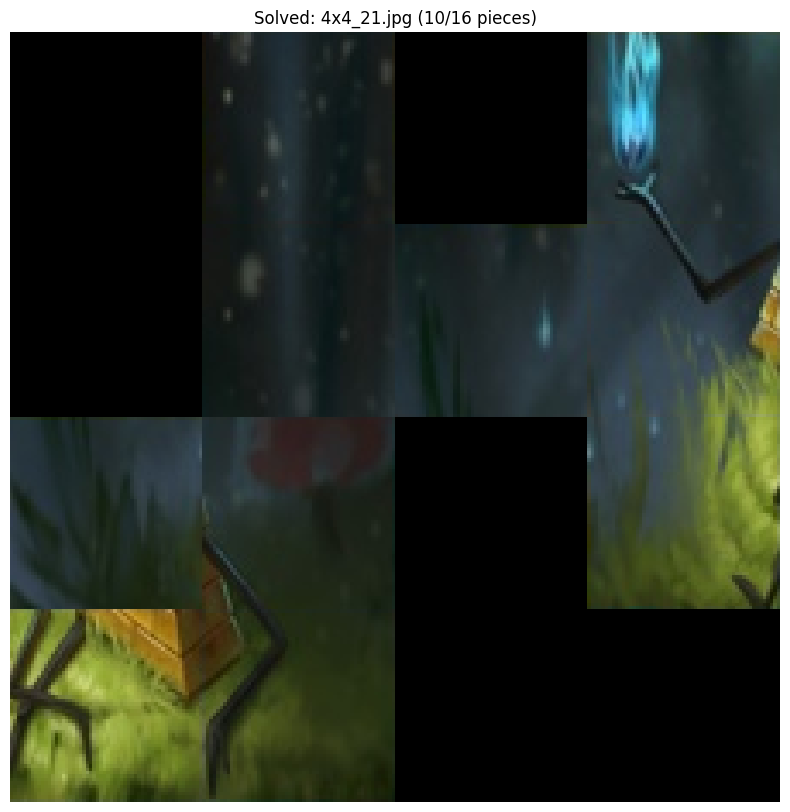

In [61]:
def solve_and_show_pomeranz(target_image_name):
    """
    Solves a specific puzzle image using the Pomeranz algorithm and displays the result.
    """
    # Configuration (Adjust paths if necessary)
    json_path = r"Tests/test_001/extractor_runs/20251213_033802/descriptors.json"
    image_dir = r"Tests/test_001/images"
    
    # 1. Load Descriptors
    if not os.path.exists(json_path):
        print(f"Error: Descriptor file not found at {json_path}")
        return

    with open(json_path, 'r') as f:
        descriptors = json.load(f)
    
    # Filter for specific image
    samples = [d for d in descriptors if d['source_image'] == target_image_name]
    samples.sort(key=lambda x: x['id'])
    
    if not samples:
        print(f"No descriptors found for {target_image_name}")
        return

    # 2. Load Image and Extract Pieces
    img_path = os.path.join(image_dir, target_image_name)
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return
        
    full_image = cv2.imread(img_path)
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    
    pieces = []
    for sample in samples:
        bbox = sample['bbox']
        x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
        crop = full_image[y:y+h, x:x+w]
        pieces.append(crop)
        
    # 3. Solve
    print(f"Solving {target_image_name} using Pomeranz (L0.3 + Best Buddies)...")
    solved_cluster = solve_puzzle_pomeranz(pieces)
    
    if not solved_cluster:
        print("Solver failed to assemble any pieces.")
        return

    # 4. Visualize Result
    n_pieces = len(pieces)
    h_piece, w_piece, _ = pieces[0].shape
    
    # Get bounds of the assembled cluster
    rs = [p[0] for p in solved_cluster.values()]
    cs = [p[1] for p in solved_cluster.values()]
    min_r, max_r = min(rs), max(rs)
    min_c, max_c = min(cs), max(cs)
    
    canvas_h = (max_r - min_r + 1) * h_piece
    canvas_w = (max_c - min_c + 1) * w_piece
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
    
    for pid, (r, c) in solved_cluster.items():
        norm_r = r - min_r
        norm_c = c - min_c
        canvas[norm_r*h_piece:(norm_r+1)*h_piece, norm_c*w_piece:(norm_c+1)*w_piece] = pieces[pid]
        
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    plt.title(f"Solved: {target_image_name} ({len(solved_cluster)}/{n_pieces} pieces)")
    plt.axis('off')
    plt.show()

# Example Usage:
solve_and_show_pomeranz("4x4_21.jpg")